# Synthetic data, Hawkes processes

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pointprocesses as ppr

In [3]:
import torch
from torch import nn

In [4]:
torch.manual_seed(1)

In [5]:
import os
import sys
import tqdm

In [6]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

Notebook dir /home/manifold/Documents/etudes/map511-p3a


In [7]:
for path in sys.path:
    print(path)


/home/manifold/Documents/etudes/map511-p3a/notebooks
/home/manifold/miniconda3/envs/pytorch/lib/python37.zip
/home/manifold/miniconda3/envs/pytorch/lib/python3.7
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.4.1-py3.7-linux-x86_64.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions
/home/manifold/.ipython
/home/manifold/Documents/etudes/map511-p3a


The standard Hawkes model has an underlying intensity given by
$$
    \lambda_t = \lambda^0_t + \int_0^t g(t-s)\,dN_s
$$
where the function $g \geq 0$ is called the _kernel_.

Here we simulate Hawkes processes with kernel $g(t) = \alpha\exp(-\delta t)$.

In [8]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

In [9]:
import itertools
mu = 1.0
tmax = 60.0
alpha = 0.2
beta  = 5
avg_num_of_events = tmax*mu/(1.-alpha/beta)
print("Expected avg evt no. %.3f" % avg_num_of_events)

Expected avg evt no. 62.500


In [10]:
n_traj = 1000
sample_trajectories = [
    torch.from_numpy(ppr.hawkes_exp(tmax, beta, mu, itertools.repeat(alpha)))
    for _ in range(n_traj)
]

print("Number of samples: \t\t%d" % len(sample_trajectories))
seq_lengths = torch.LongTensor([s.shape[0] for s in sample_trajectories])
input_size = seq_lengths.max().item()
print("Input size max. traj. length: \t%d" % input_size)
print("tmax = %.3f"  % tmax)
print("Empirical average %.3f" % seq_lengths.to(torch.float).mean().item())

data_tensor = nn.utils.rnn.pad_sequence(sample_trajectories).to(torch.float)
# Sort the sequences by decreasing length
seq_lengths, order_index_ = seq_lengths.sort(descending=True) # first sort the tensor of lengths
data_tensor = data_tensor[:, order_index_, :]
# Extract only times, append a beginning of sequence event
times_tensor = data_tensor[:,:,0]
# times_tensor = torch.cat((torch.zeros(1,times_tensor.shape[1]), times_tensor), dim=0)
# seq_lengths += 1

Number of samples: 		1000
Input size max. traj. length: 	90
tmax = 60.000
Empirical average 62.413


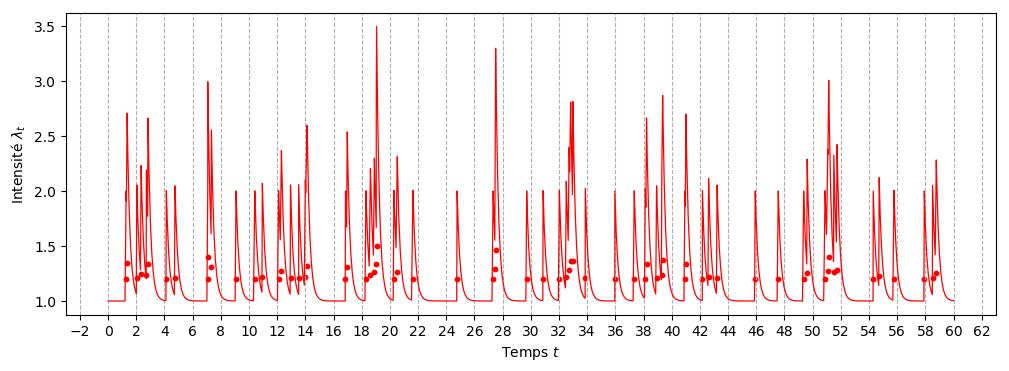

In [11]:
one_traj = sample_trajectories[1].numpy()
fig, ax = plt.subplots(1,1, figsize=(12,4), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel(r"Intensité $\lambda_t$")
t_arr = np.sort(np.append(np.linspace(0, tmax, 600), one_traj[:,0]))
ax.plot(t_arr, intensity_function(t_arr, mu, alpha, beta, one_traj[:,0]), 'r-', linewidth=0.9)
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.))
scatter_opts = {
    "c": "r", "s": 11
}
ax.grid(True, axis='x', linestyle='--')
ax.scatter(one_traj[:,0], one_traj[:,1], c='r', s=10)

We will pad each sequence with 0s at the end.

Text(0, 0.5, 'Number')

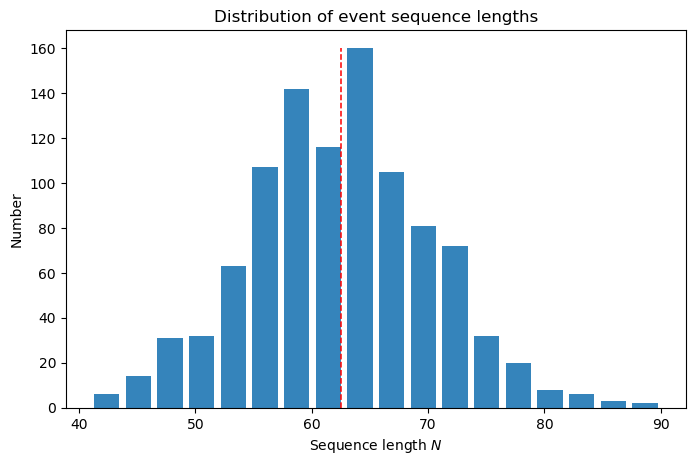

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
arr, bins, patches = ax.hist(seq_lengths,
                             bins=2*int(seq_lengths.size(0)**(1/3)),
                             rwidth=0.8, alpha=0.9)
ax.set_title('Distribution of event sequence lengths')
ax.vlines(avg_num_of_events, 0., arr.max(),
          linestyles="--", linewidth=1.1, color="r")
ax.set_xlabel('Sequence length $N$')
ax.set_ylabel('Number')

In [13]:
data_tensor.shape

torch.Size([90, 1000, 3])

## Save the tensor down to a file

In [15]:
import pickle
filepath = "../data/simulated/hawkes_sim_tensor_save.pkl"
with open(filepath, "wb") as f:
    save_data_ = {
        "mu": mu,
        "alpha": alpha,
        "decay": beta,
        "tmax": tmax,
        "data": data_tensor,
        "lengths": seq_lengths
    }
    pickle.dump(save_data_, f)